In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [34]:
print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 6GB Laptop GPU
Using device: cuda


In [35]:
new_df = pd.read_csv('sentiment_scored.csv')

In [36]:
new_df = new_df.sort_values(by='timestamp')

In [37]:
new_df.drop(columns=['Unnamed: 0'],inplace=True)

In [38]:
new_df.head()

,rating,text,timestamp,rob_neg,rob_neu,rob_pos
11566,4,Easy to use. Non invasive. Vibrates with resul...,2018-05-11 17:21:49.173,0.001923,0.027694,0.970383
15082,5,This is the easiest thermometer that gives the...,2018-05-12 18:36:23.059,0.001951,0.032199,0.965850
1903,5,Easy to use. Easy to read display. Light weigh...,2018-05-13 00:28:58.218,0.005065,0.083532,0.911403
15180,4,I like that you don't touch the skin; that it ...,2018-05-24 16:19:08.822,0.216497,0.496322,0.287181
15771,4,My only complaint is that it does not work wit...,2018-05-24 17:02:23.110,0.350157,0.382552,0.267292


### Performing Moving Average

In [39]:
new_df['timestamp'] = pd.to_datetime(new_df['timestamp'], errors='coerce')

In [40]:
new_df['moving_average_neg'] = new_df['rob_neg'].rolling(window=30, min_periods=1).mean()
new_df['moving_average_neu'] = new_df['rob_neu'].rolling(window=30, min_periods=1).mean()
new_df['moving_average_pos'] = new_df['rob_pos'].rolling(window=30, min_periods=1).mean()

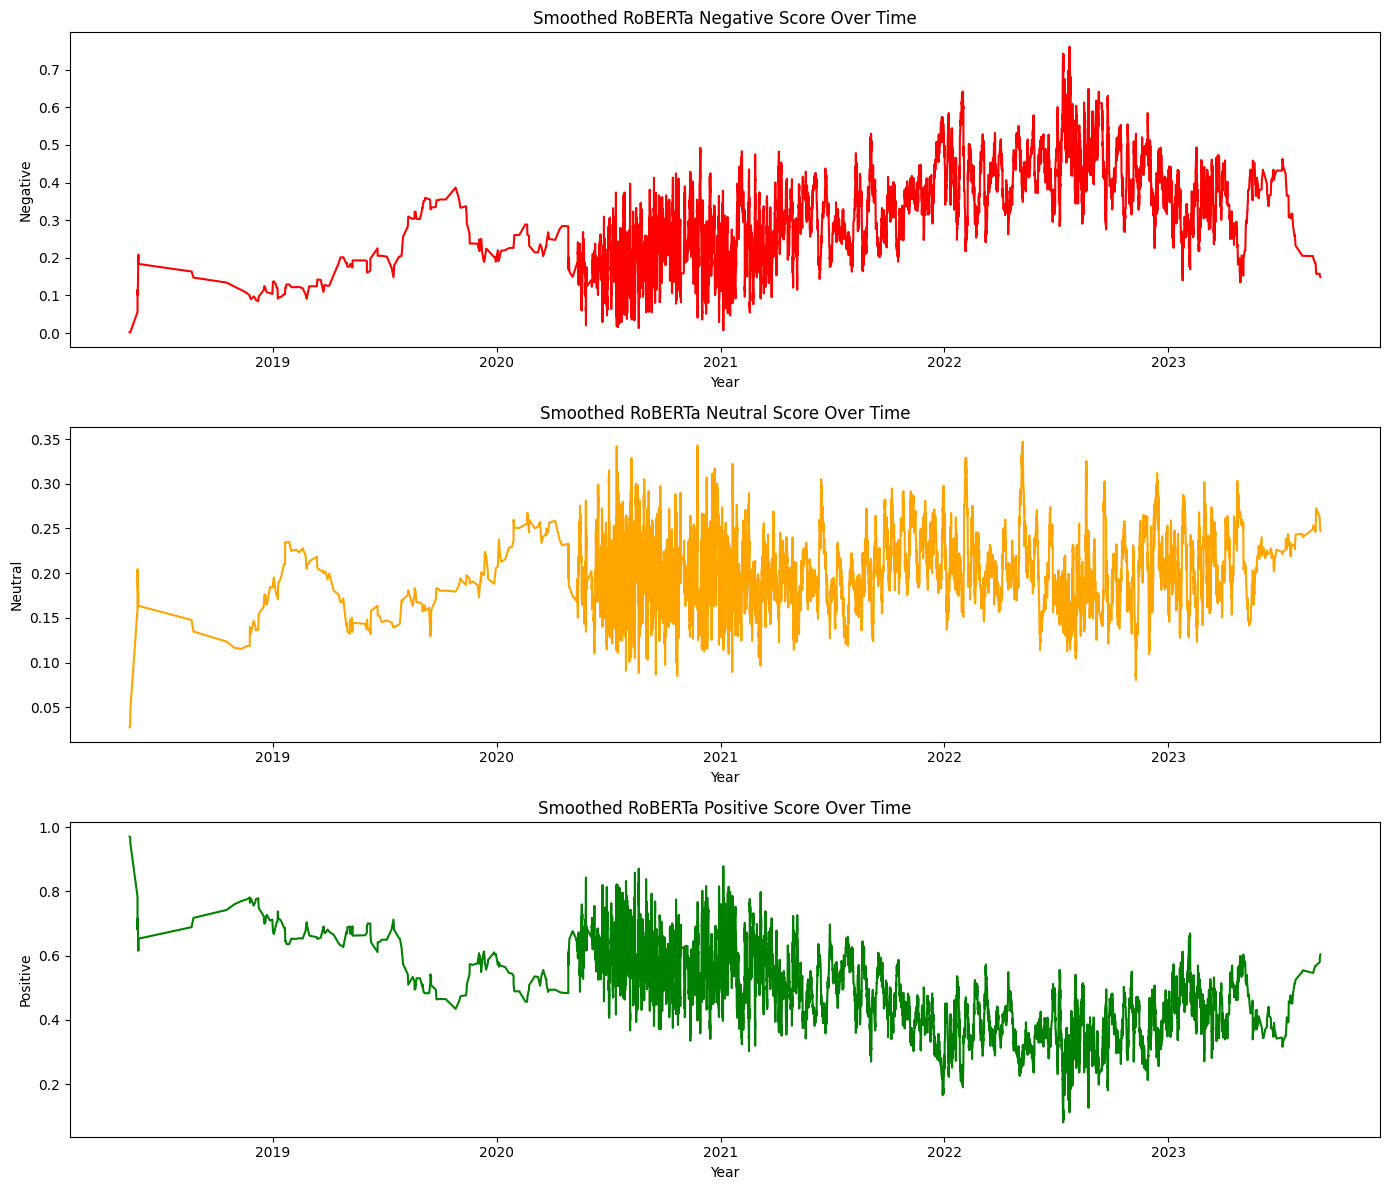

In [41]:
fig, arr = plt.subplots(3, 1, figsize=(14, 12))

arr[0].plot(new_df['timestamp'], new_df['moving_average_neg'], color='red')
arr[0].set_title("Smoothed RoBERTa Negative Score Over Time")
arr[0].set_ylabel("Negative")
arr[0].set_xlabel("Year")

arr[1].plot(new_df['timestamp'], new_df['moving_average_neu'], color='orange')
arr[1].set_title("Smoothed RoBERTa Neutral Score Over Time")
arr[1].set_ylabel("Neutral")
arr[1].set_xlabel("Year")

arr[2].plot(new_df['timestamp'], new_df['moving_average_pos'], color='green')
arr[2].set_title("Smoothed RoBERTa Positive Score Over Time")
arr[2].set_ylabel("Positive")
arr[2].set_xlabel("Year")

plt.tight_layout()
plt.show()


In [42]:
class Forecast_Sentiments:
    
    def __init__(self):
        self.WINDOW_SIZE = 180
        self.X = None
        self.y = None
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.cp = None
        self.model1 = None
        self.history = None
        self.best_model = None
        self.pos_result = None
        self.earlystopping = EarlyStopping( 
                            monitor="val_loss",
                            patience=1,
                            verbose=1,
                            mode="min",)
    
    def df_to_X_y(self,df,window_Size = 180):
        df_as_numpy = df.to_numpy()
        X = []
        y = []
        for i in tqdm(range(len(df_as_numpy) - window_Size)):
            row = [[a] for a in df_as_numpy[i:i + window_Size]]
            X.append(row)
            label = df_as_numpy[i + window_Size]
            y.append(label)

        self.X = np.array(X)
        self.y = np.array(y)
    
    def split_data_points(self,size = 12000):
        self.X_train , self.y_train = np.array(self.X[:size]), np.array(self.y[:size])
        self.X_test , self.y_test = np.array(self.X[size:]) , np.array(self.y[size:])
        
    
    def train_stacked_lstm_model(self, learning_rate=0.001):
        self.model1 = Sequential()
        self.model1.add(InputLayer((self.WINDOW_SIZE, 1)))

        self.model1.add(LSTM(64, return_sequences=True))
        self.model1.add(Dropout(0.2))

        self.model1.add(LSTM(64, return_sequences=True))
        self.model1.add(Dropout(0.2))

        self.model1.add(LSTM(64))
        self.model1.add(Dropout(0.2))

        self.model1.add(Dense(8, activation='relu'))
        self.model1.add(Dense(1, activation='linear'))

        self.model1.summary()

        self.cp = ModelCheckpoint('model1_best.keras', save_best_only=True)

        self.model1.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=learning_rate),metrics=[RootMeanSquaredError()])
        
    def fit_model(self,epochs = 50):
        self.history = self.model1.fit(
        self.X_train,
        self.y_train,
        validation_split=0.2,
        epochs=epochs,
        callbacks=[self.cp, self.earlystopping]
        )

        plt.figure(figsize=(10, 5))
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Training vs Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
            
        
        
    
    def forecast_model(self):
        self.best_model = load_model('model1_best.keras')
        temp = self.best_model.predict(self.X_test)
        return pd.DataFrame(data = {'Test Prediction' : temp.flatten(),'Actual' : self.y_test})
        
    
    def evaluation(self,model):
        
        mse = mean_squared_error(model['Test Prediction'],model['Actual'])
        rmse = np.sqrt(mse)
        r2 = r2_score(model['Test Prediction'],model['Actual'])
        mae = mean_absolute_error(model['Test Prediction'],model['Actual'])

        print('mse : ',mse)
        print('rmse : ',rmse)
        print('r2 : ',r2)
        print('mae : ',mae)
        
        
    def forecast_visual(self,model,text):
        plt.figure(figsize=(12, 5))

        plt.plot(model['Test Prediction'], color='blue', label='Predicted')
        plt.plot(model['Actual'], color='red', label='Actual')

        plt.title(f'{text} Sentiment Model Prediction vs Actual Values')
        plt.xlabel('Time Step')
        plt.ylabel('Sentiment Score')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
    

In [43]:
negative_sentiment = Forecast_Sentiments()
neutral_sentiment = Forecast_Sentiments()
positive_sentiment = Forecast_Sentiments()


### Peforming Model For Negative Sentiment

In [44]:
negative_sentiment.df_to_X_y(new_df['moving_average_neg'])

100%|██████████| 16677/16677 [00:02<00:00, 7024.98it/s]


In [45]:
negative_sentiment.split_data_points()

In [46]:
negative_sentiment.train_stacked_lstm_model(learning_rate=0.001)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 180, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 180, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 180, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 180, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,473 (326.07 KB)

 Trainable params: 83,473 (326.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - loss: 0.0042 - root_mean_squared_error: 0.0608 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0323
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - loss: 9.5203e-04 - root_mean_squared_error: 0.0308 - val_loss: 7.2446e-04 - val_root_mean_squared_error: 0.0269
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - loss: 7.0017e-04 - root_mean_squared_error: 0.0264 - val_loss: 5.1838e-04 - val_root_mean_squared_error: 0.0228
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 81ms/step - loss: 5.2259e-04 - root_mean_squared_error: 0.0228 - val_loss: 5.3419e-04 - val_root_mean_squared_error: 0.0231
Epoch 4: early stopping


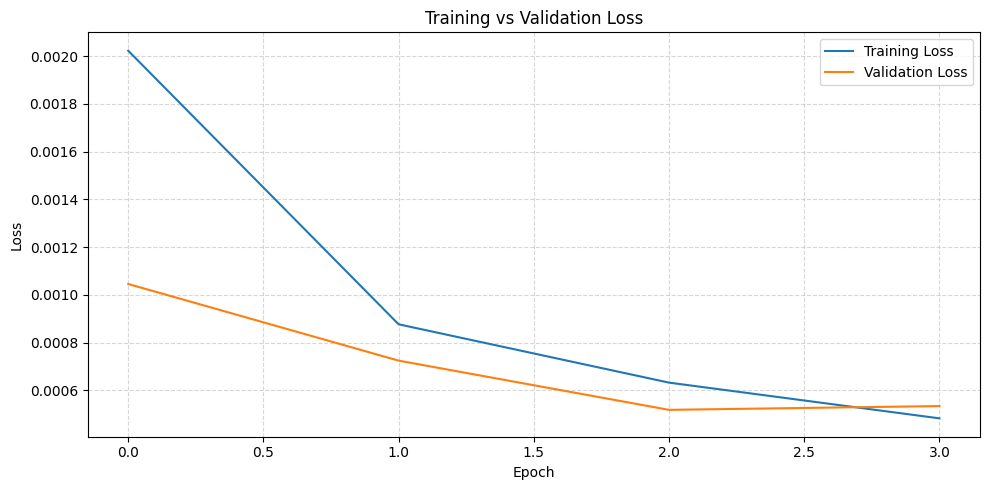

In [47]:
negative_sentiment.fit_model()

In [48]:
negative_sentiment_model = negative_sentiment.forecast_model()

147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step


In [49]:
negative_sentiment.evaluation(negative_sentiment_model)

mse :  0.0007381552587959619
rmse :  0.027169012841764456
r2 :  0.9132063573035814
mae :  0.021828108762056667


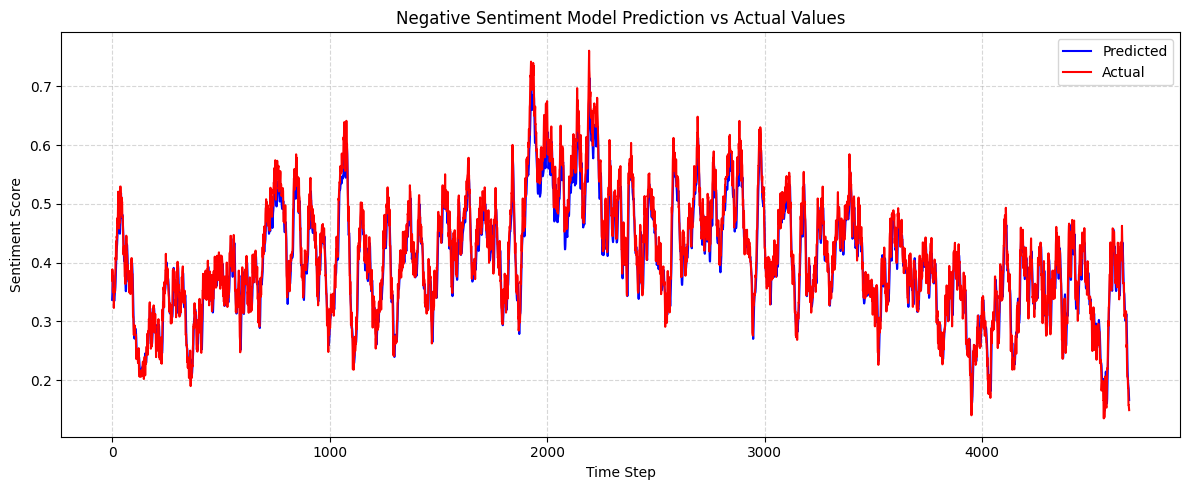

In [50]:
negative_sentiment.forecast_visual(negative_sentiment_model,text = 'Negative')

### Peforming Model For Positive Sentiment

In [51]:
positive_sentiment.df_to_X_y(new_df['moving_average_pos'])

100%|██████████| 16677/16677 [00:01<00:00, 8958.06it/s]


In [52]:
positive_sentiment.split_data_points()

In [53]:
positive_sentiment.train_stacked_lstm_model(learning_rate=0.0001)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 180, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 180, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 180, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 180, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,473 (326.07 KB)

 Trainable params: 83,473 (326.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - loss: 0.1538 - root_mean_squared_error: 0.3676 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0785
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - loss: 0.0080 - root_mean_squared_error: 0.0892 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0717
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - loss: 0.0065 - root_mean_squared_error: 0.0805 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0607
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 81ms/step - loss: 0.0057 - root_mean_squared_error: 0.0754 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0590
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 81ms/step - loss: 0.0050 - root_mean_squared_error: 0.0706 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0524
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 25s 82ms/step - loss: 0.0045 - root_mean_squared_error: 0.0673 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0516
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 

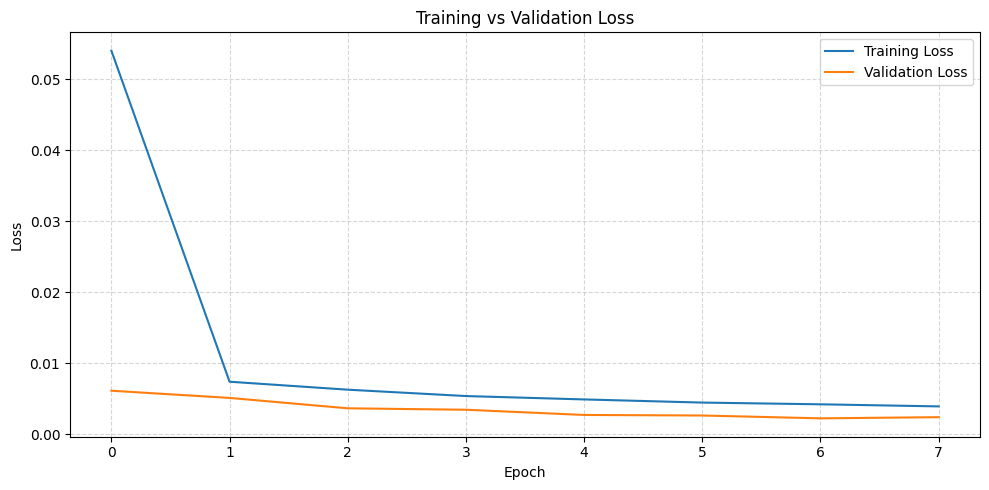

In [54]:
positive_sentiment.fit_model()

In [55]:
positive_sentiment_model = positive_sentiment.forecast_model()

147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step


In [56]:
positive_sentiment.evaluation(positive_sentiment_model)

mse :  0.004098343825224078
rmse :  0.06401830851579943
r2 :  0.15403801299685138
mae :  0.05250824628235382


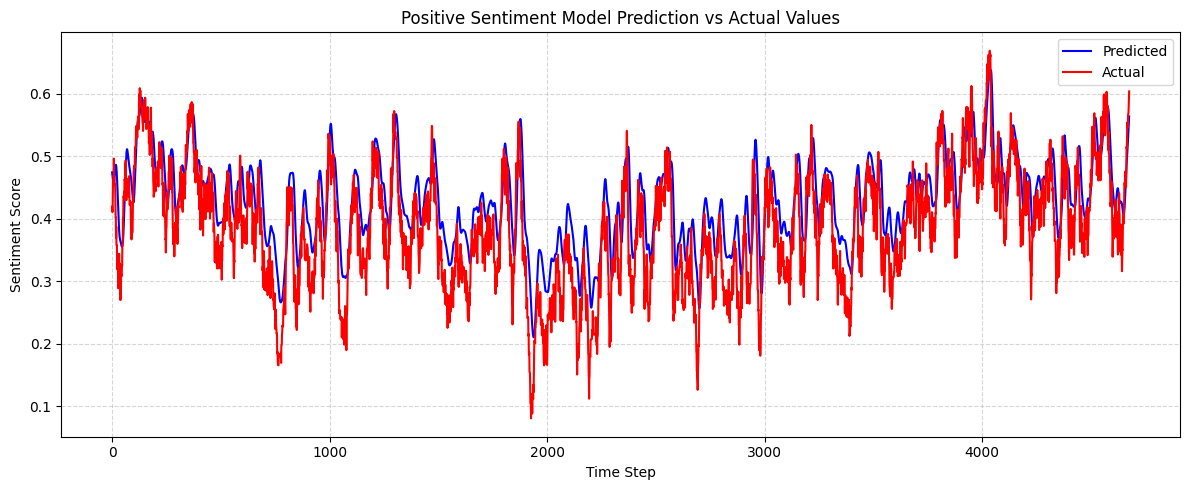

In [57]:
positive_sentiment.forecast_visual(positive_sentiment_model,text='Positive')

### Performing Model For Neutral sentiment

In [58]:
neutral_sentiment.df_to_X_y(new_df['moving_average_neu'])

100%|██████████| 16677/16677 [00:02<00:00, 6619.07it/s]


In [59]:
neutral_sentiment.split_data_points()

In [60]:
neutral_sentiment.train_stacked_lstm_model(learning_rate=0.001)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 180, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 180, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 180, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 180, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,473 (326.07 KB)

 Trainable params: 83,473 (326.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 81ms/step - loss: 0.0035 - root_mean_squared_error: 0.0536 - val_loss: 3.2978e-04 - val_root_mean_squared_error: 0.0182
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 25s 83ms/step - loss: 5.7520e-04 - root_mean_squared_error: 0.0240 - val_loss: 2.7029e-04 - val_root_mean_squared_error: 0.0164
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 81ms/step - loss: 4.3356e-04 - root_mean_squared_error: 0.0208 - val_loss: 2.4251e-04 - val_root_mean_squared_error: 0.0156
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 25s 83ms/step - loss: 3.2662e-04 - root_mean_squared_error: 0.0181 - val_loss: 1.6114e-04 - val_root_mean_squared_error: 0.0127
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 25s 82ms/step - loss: 2.5803e-04 - root_mean_squared_error: 0.0161 - val_loss: 1.3277e-04 - val_root_mean_squared_error: 0.0115
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 25s 83ms/step - loss: 1.9176e-04 - root_mean_squared_error: 0.0138 - val_loss: 1.3445e-04 - val_root_mean_squared_error: 0.0

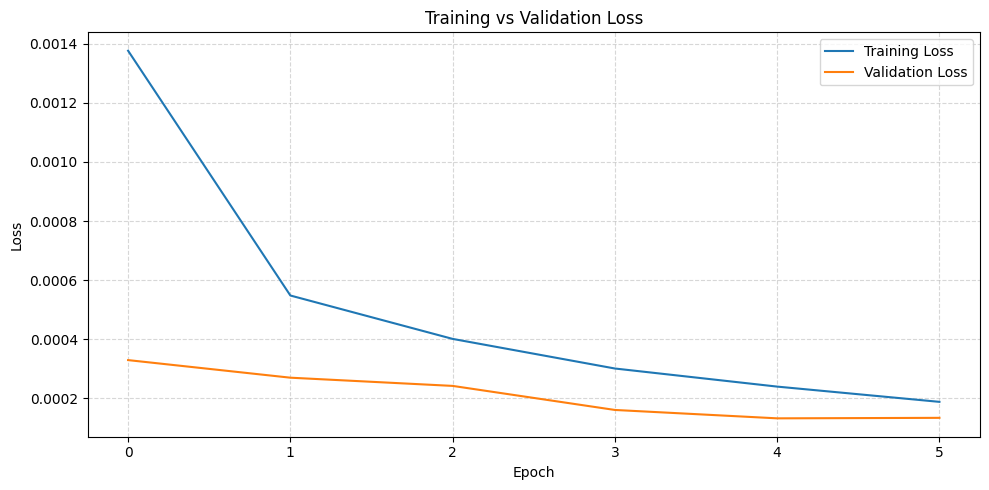

In [61]:
neutral_sentiment.fit_model()

In [62]:
neutral_sentiment_model = neutral_sentiment.forecast_model()

147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step


In [63]:
neutral_sentiment.evaluation(neutral_sentiment_model)

mse :  0.00014317007250543498
rmse :  0.011965369718710534
r2 :  0.8970992999358904
mae :  0.009308619482495208


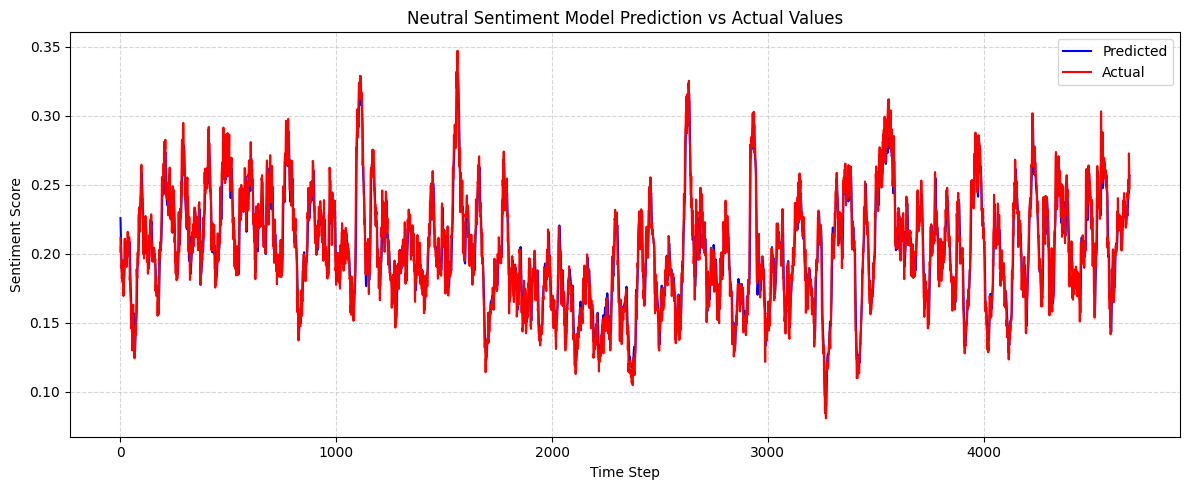

In [64]:
neutral_sentiment.forecast_visual(neutral_sentiment_model,text='Neutral')